### Generalized Methods of Moments Estimation of Stochastic Volatility Models - Andersen & Sorensen (1996)

#### TODO: Find the correct lag number & find the best (or a correct) weighting matrix estimator

In [27]:
library(MASS)

In [28]:
sv_simul <- function(theta, log_sigma0, T){
    y_t <- c()
    log_sigma2 <- c()
    omega <- theta[1]
    beta <- theta[2]
    sigma_u <- theta[3]
    
    mean <- matrix(c(0,0), nrow=2, ncol=1)
    std <- matrix(c(1, 0, 0, 1), nrow=2, ncol=2)
    resid <- mvrnorm(T, mean, std)
    z_t <- resid[,1]
    u_t <- resid[,2]
    
    log_sigma2[1] <- omega + beta * log_sigma0 + sigma_u * u_t[1]
    y_t[1] <- sqrt(exp(log_sigma2[1])) * z_t[1]
    
    for (t in 2:T){
        log_sigma2[t] <- omega + beta * log_sigma2[t-1] + sigma_u * u_t[t]
        y_t[t] <- sqrt(exp(log_sigma2[t])) * z_t[t]
    }

    sigma_t <- sqrt(exp(log_sigma2))
    
    list(y_t, sigma_t)
}

In [29]:
# Inputs
T <- 3000
omega <- -0.736
beta <- 0.9
sigma_u <- 0.363
theta <- c(omega, beta, sigma_u) 
log_sigma0 <- -0.1

In [30]:
data <- sv_simul(theta, log_sigma0, T)
y_t <- unlist(data[1])
sigma_t <- unlist(data[2])

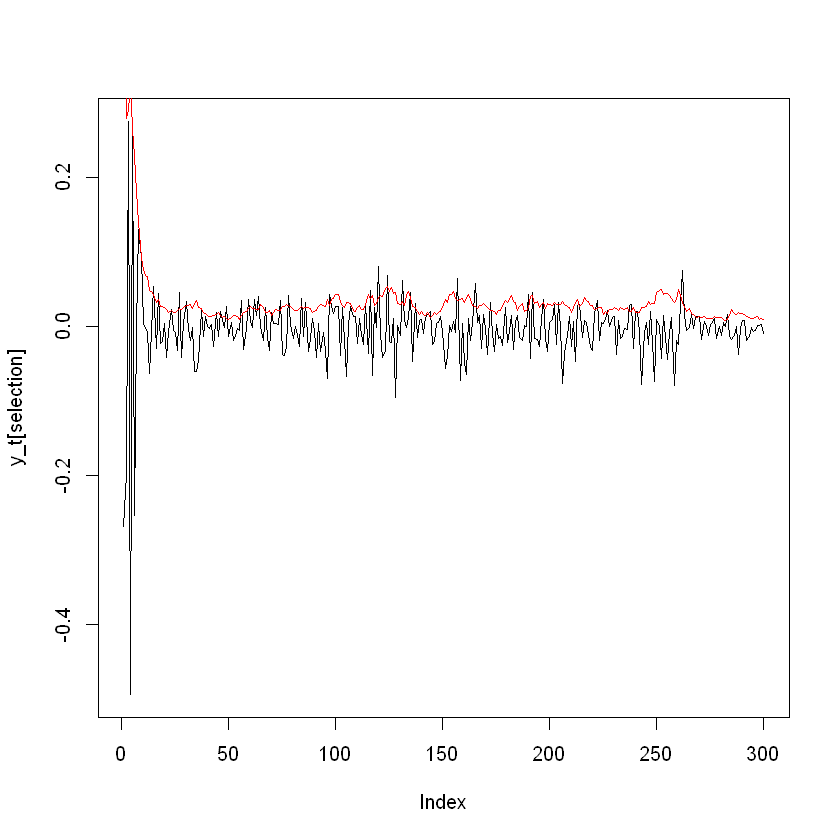

In [31]:
selection <- 1:300
plot(y_t[selection], type='l')
lines(sigma_t[selection], type='l', col='red')

### Estimation Method

###### Analytical Expression

In [32]:
simple_moment <- function(r, mu, sigma2){
    result <- exp(r * mu/2 + r**2 * sigma2 / 8)
    result
}

In [33]:
double_moment <- function(i, r, s, mu, sigma2){
    moment1 <- simple_moment(r, mu, sigma2)
    moment2 <- simple_moment(s, mu, sigma2)
    result <- moment1 * moment2 * exp(r * s * beta**i * sigma2/4)
    result
}

In [34]:
theta

[1] -0.736  0.900  0.363

In [35]:
mu <- omega / (1 - beta)
sigma2 <- sigma_u**2 / (1-beta**2)
sigma2

[1] 0.6935211

In [36]:
obj_GMM <- function(theta, para_nb, j, y_t, L_T){
    
    T <- length(y_t)
    omega <- theta[1]
    beta <- theta[2]
    sigma_u <- theta[3]

    A_vec <- matrix(0, nrow=mom_nb, ncol=1)
    M_T <- matrix(0, nrow=mom_nb, ncol=1)
    m_t <- matrix(0, nrow=T, ncol=mom_nb)

    mu <- omega / (1 - beta)
    sigma2 <- sigma_u**2 / (1-beta**2)
    A_vec[1,1] <- sqrt(2*pi) * simple_moment(1, mu, sigma2)
    A_vec[2,1] <- simple_moment(2, mu, sigma2)
    A_vec[3,1] <- 2*sqrt(2/pi) * simple_moment(3, mu, sigma2)
    A_vec[4,1] <- 3 * simple_moment(4, mu, sigma2)

    for (i in 1:10){
        A_vec[4+i,1] <- 2/pi * double_moment(i, 1, 1, mu, sigma2)
        A_vec[14+i,1] <- double_moment(i, 2, 2, mu, sigma2)
    }

    m_t[,1] <- abs(y_t)
    m_t[,2] <- y_t**2
    m_t[,3] <- abs(y_t**3)
    m_t[,4] <- y_t**4
    
    M_T[1,] <- mean(m_t[(j+1):T, 1])
    M_T[2,] <- mean(m_t[(j+1):T, 1])
    M_T[3,] <- mean(m_t[(j+1):T, 1])
    M_T[4,] <- mean(m_t[(j+1):T, 1])
    
    for (i in 1:10){
        m_t[,4+i] <- abs(y_t[(i+1):T] * y_t[1:(T-i)])
        m_t[,14+i] <- abs(y_t[(i+1):T]**2 * y_t[1:(T-i)]**2)
        
        M_T[4+i,] <- mean(m_t[,4+i])
        M_T[14+i,] <- mean(m_t[,14+i])
    }
    
    # Computation of Nabla
    Gamma_T <- c()
    for (z in 1:(2*(T-1))){
        j_int <- z - (T-1)
        1: T * sum((m_t[(j_int+1):T,] - A_vec[,1]) %*%
                   t((m_t[1:(T-j_int),] - A_vec[,1])))
    }
    
    
    k_vec <- c()
    for (z in 1:(2*(T-1))){
        if (z < L_T){
            k_vec[z] <- 1 - z / L_T
        }
        else {
            k_vec[z] <- 0
        }
    }
    
    Nabla <- diag(mom_nb)
    Nabla_inv <- solve(Nabla)
    
    result <- t(M_T - A_vec) %*% Nabla_inv %*% (M_T - A_vec)
}

In [37]:
estim_GMM <- function(theta_init, para_nb, j, y_t, L_T){
    valinit <- theta_init
    lower = c(-Inf, 0, 0)
    upper = c(Inf, 1, Inf)
    res <- nlminb(valinit, obj_GMM, lower=lower, upper=upper, para_nb=para_nb,
                  j=j, y_t=y_t, L_T=L_T)
    omega <- res$par[1]
    beta <- res$par[2]
    sigma_u <- res$par[3]
    list(coef=c(omega, beta, sigma_u))
}

In [38]:
theta_init <- c(-0.5, 0.85, 0.3)
mom_nb <- 24
j <- 0

# Check algorithm running time
start.time <- Sys.time()

In [39]:
estimation <- estim_GMM(theta_init, para_nb, j, y_t)
theta_hat <- estimation$coef
theta_hat <- matrix(theta_hat)

ERROR: Error in m_t[, 4 + i] <- abs(y_t[(i + 1):T] * y_t[1:(T - i)]): number of items to replace is not a multiple of replacement length


In [43]:
estim_GMM(theta_init, para_nb, j, y_t)

ERROR: Error in m_t[, 4 + i] <- abs(y_t[(i + 1):T] * y_t[1:(T - i)]): number of items to replace is not a multiple of replacement length


In [ ]:
theta_hat
theta

In [ ]:
end.time <- Sys.time()
time.taken<-round(end.time-start.time,2)
time.taken

#### Monte Carlo Experiment

In [ ]:
# Inputs
M <- 1000

In [ ]:
spread_conso <- matrix(0, nrow=M, ncol=3)

for (j in 1:M){
    # Simulation
    data <- sv_simul(theta, log_sigma0, T)
    y_t <- unlist(data[1])
    sigma_t <- unlist(data[2])
    
    estimation <- estim_GMM(theta_init, para_nb, j, y_t)
    theta_hat <- estimation$coef
    theta_hat <- matrix(theta_hat)
    
    spread_conso[j,] <- theta_hat - theta
}

In [ ]:
boxplot(spread_conso[,1])
boxplot(spread_conso[,2])
boxplot(spread_conso[,3])

In [ ]:
mean(spread_conso[,1])
mean(spread_conso[,2])
mean(spread_conso[,3])